# Extract SOSS Traces

This notebook demonstrates how the first and second order traces are extracted from a frame of TSO data. The resulting polynomials from this technique may be used to generate simulated spectra with the `synSOSS.awesim.TSO()` class.

In [1]:
# Magic functions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Modules and variables
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from matplotlib.colors import LogNorm
from matplotlib import rc

os.chdir('../')
from AWESim_SOSS.extract1D import get1Dspectrum as spec1D

# Use CV3 data (for now)

Once JWST is on-sky, this analysis can be rerun.

Filename: AWESim_SOSS/extract1D/data/cv3_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      95   ()      
  1  SCI           1 ImageHDU        11   (2048, 256)   float32   
  2  DQ            1 ImageHDU        10   (2048, 256)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU         8   (2048, 256)   float32   
  4  ASDF          1 ImageHDU         7   (2699,)   uint8   


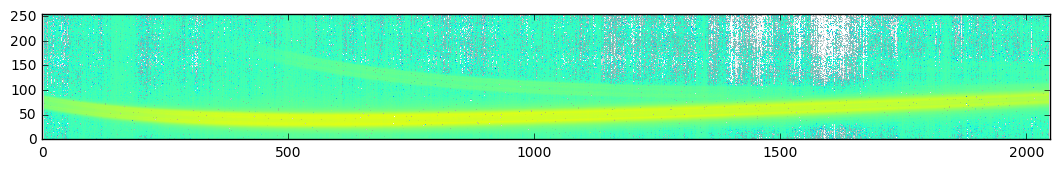

In [10]:
# Just grab a column of CV3 data
data = 'AWESim_SOSS/extract1D/data/cv3_data.fits'
HDU = fits.open(data)
HDU.info()
data = HDU[1].data.T[::-1].swapaxes(-1,-2)

# Choose a column for visual inspection
col_num = 700
COL = data[:,col_num]

# Look at the data
plt.figure(figsize=(13,2))
plt.imshow(data, origin='lower', norm=LogNorm())

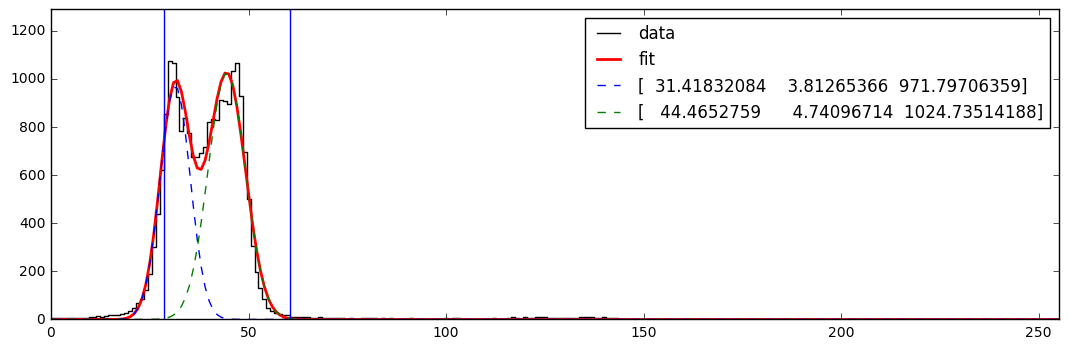

In [11]:
# Fit an unconstrained bimodal gaussian to the PSF. Better!
bounds = ([15,0,10]*2,[110,5,2500]*2)
psf = spec1D.isolate_signal(COL, func=spec1D.bimodal, bounds=bounds, plot=True)

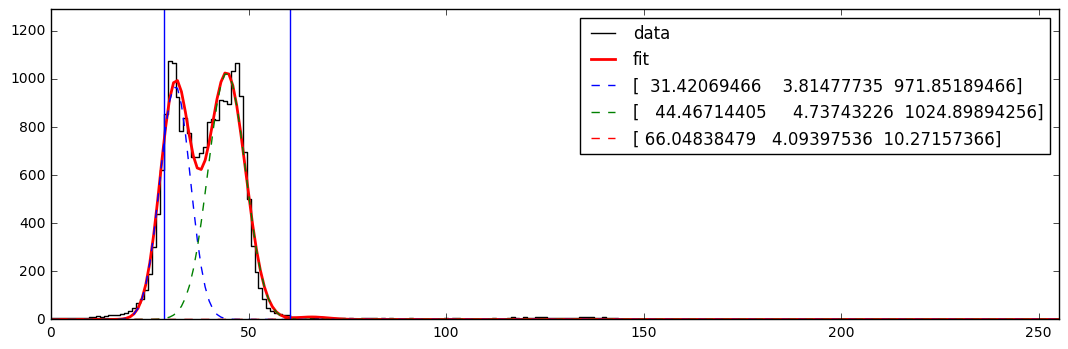

In [12]:
# Fit an unconstrained trimodal gaussian to the PSF. Worse! It picks up the second order as the third peak.
bounds = ([10,1,5,20,1,5,25,1,5],[110,5,2500]*3)
psf = spec1D.isolate_signal(COL, func=spec1D.trimodal, bounds=bounds, plot=True)

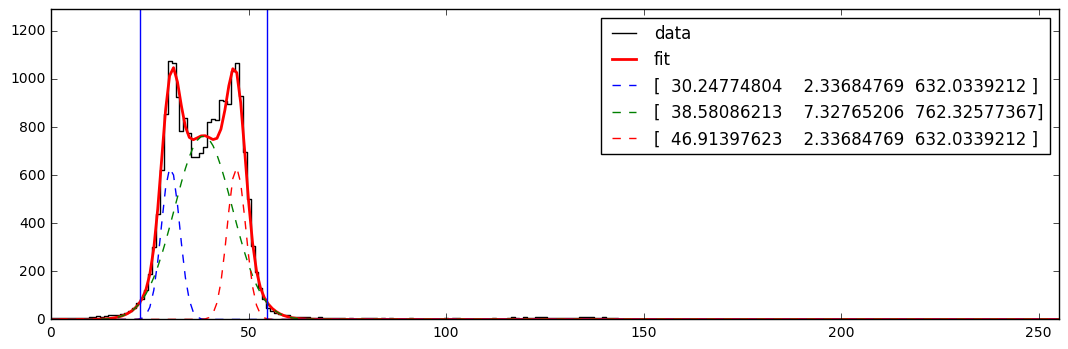

In [13]:
# Fit a batman function with constraints on the peak separation. Best!
bat_bounds = ([10,1,5,1,5,3],[110,5,2500,10,2500,30])
psf = spec1D.isolate_signal(COL, func=spec1D.batman, bounds=bat_bounds, plot=True)

# Fit only order 2

(0, 20)

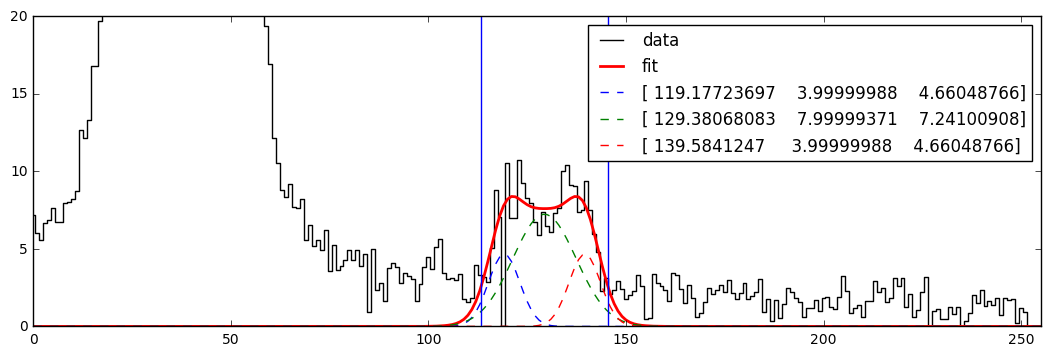

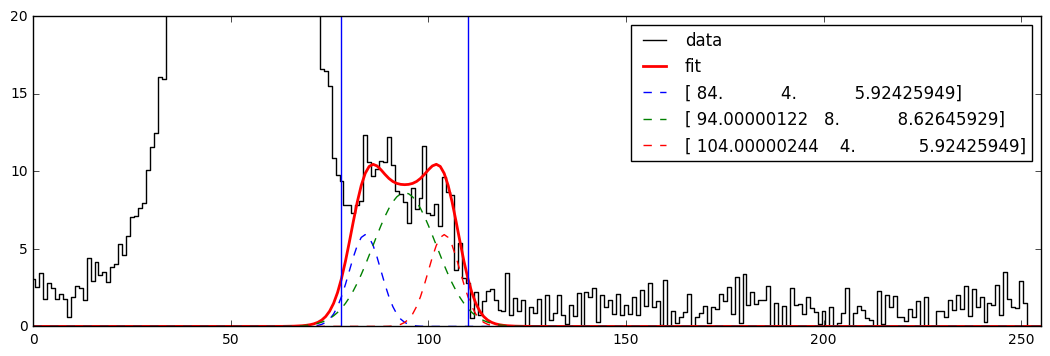

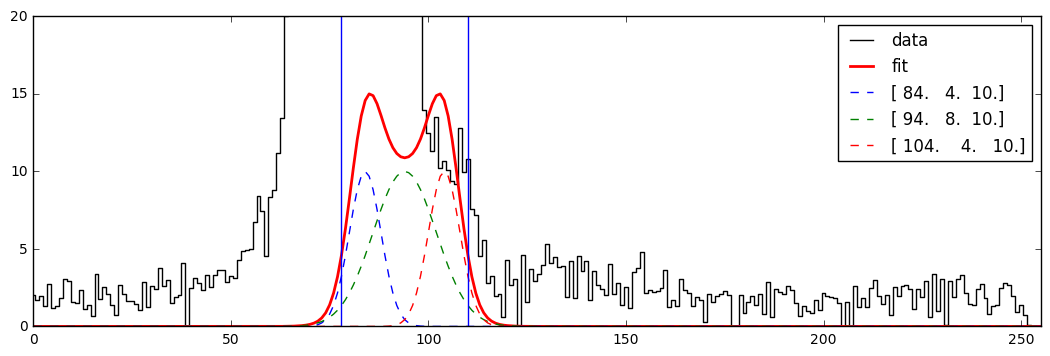

In [14]:
# Fit a batman function to only second order
bat_bounds2 = ([84,2,3,2,3,20],[150,4,10,8,10,25])

n = 700
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batman, bounds=bat_bounds2, plot=True)
plt.ylim(0,20)

n = 1300
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batman, bounds=bat_bounds2, plot=True)
plt.ylim(0,20)
         
n = 2000
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batman, bounds=bat_bounds2, plot=True)
plt.ylim(0,20)

# Fit for both orders

Looks like the second order is about 1/100 the counts of the first order, though these represent the flux at different wavelengths.

(0, 20)

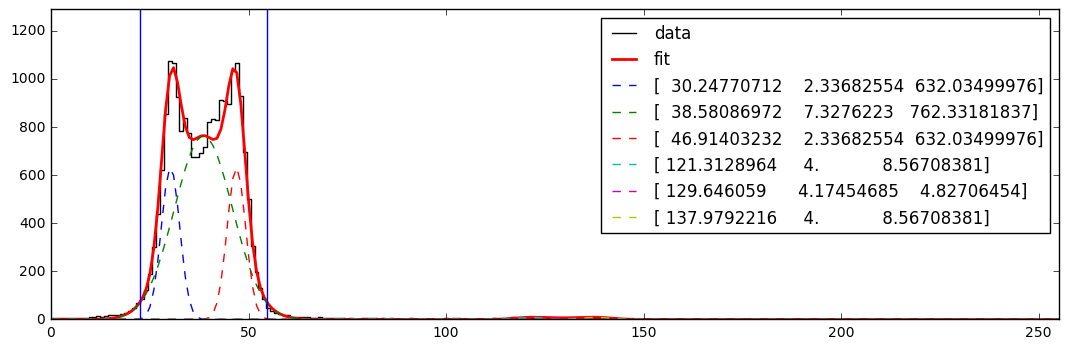

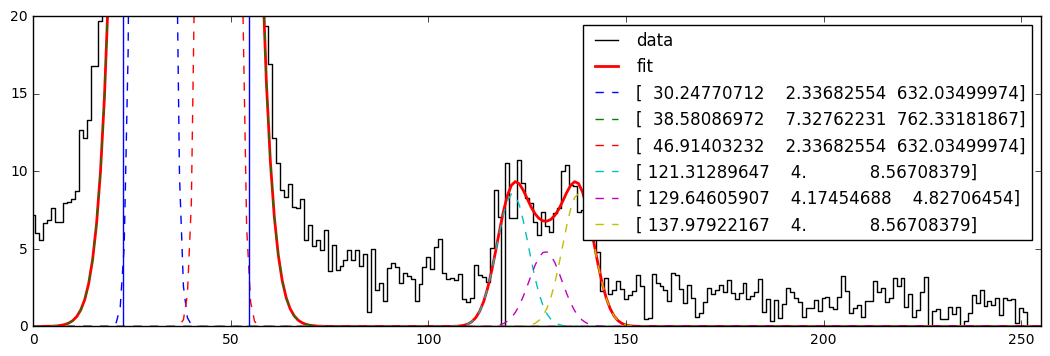

In [15]:
# Fit a batmEn function with constraints on the peak separation.
n = 700
BOUNDS = ([5,2,5,2,5,3,50,2,3,2,3],[110,5,2500,10,2500,30,125,4,10,8,10])
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batmen, bounds=BOUNDS, plot=True)
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batmen, bounds=BOUNDS, plot=True)
plt.ylim(0,20)

(0, 20)

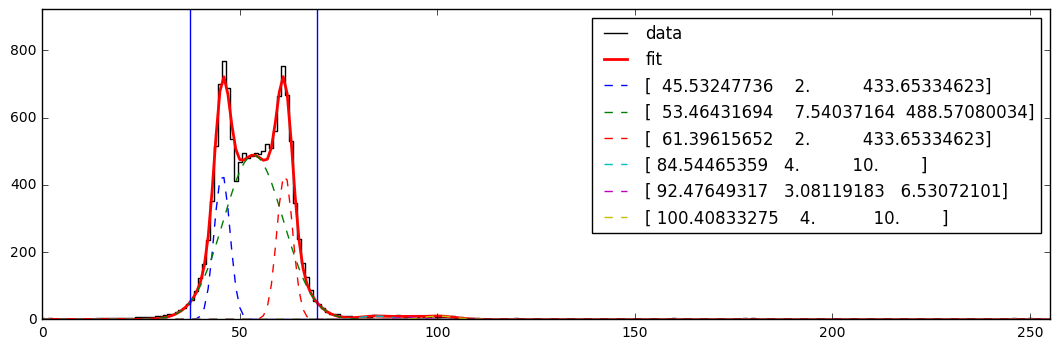

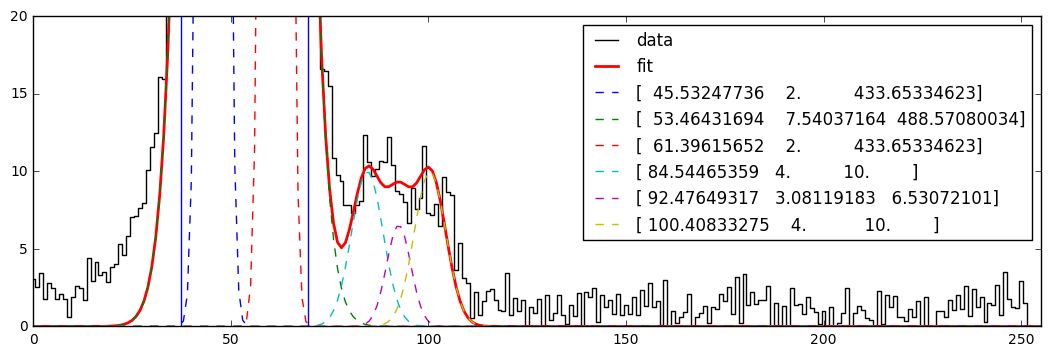

In [16]:
# Try in area with more overlap... Nice!
n = 1300
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batmen, bounds=BOUNDS, plot=True)
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batmen, bounds=BOUNDS, plot=True)
plt.ylim(0,20)

(0, 20)

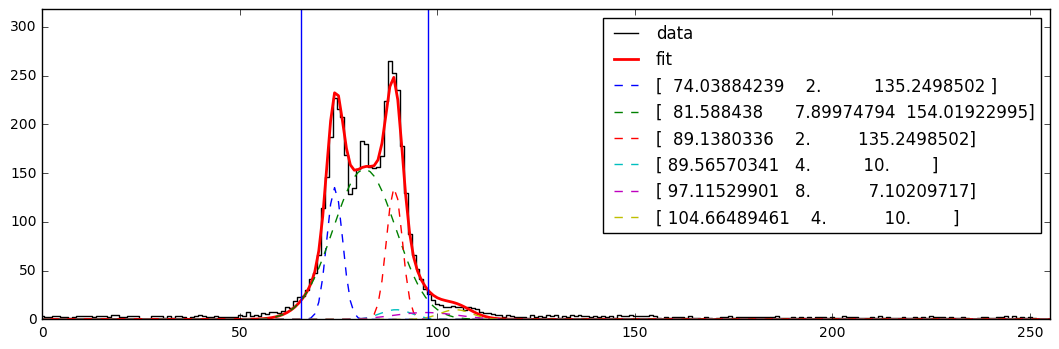

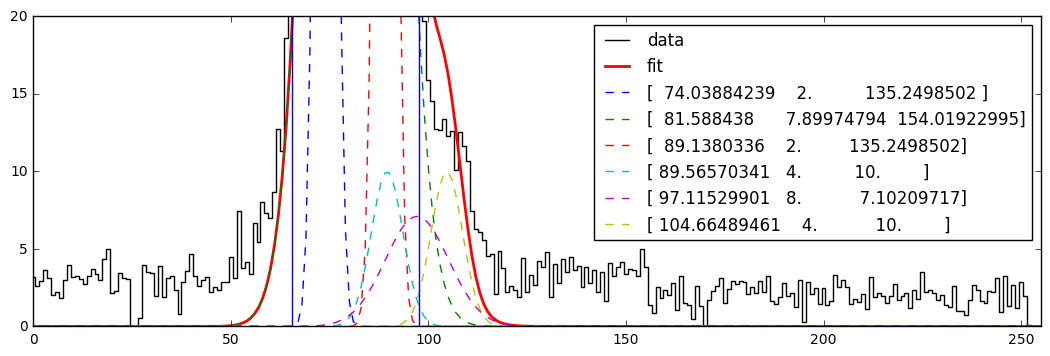

In [17]:
# Try in area with most overlap... Nice!
n = 2020
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batmen, bounds=BOUNDS, plot=True)
psf = spec1D.isolate_signal(data[:,n], func=spec1D.batmen, bounds=BOUNDS, plot=True)
plt.ylim(0,20)

(0, 20)

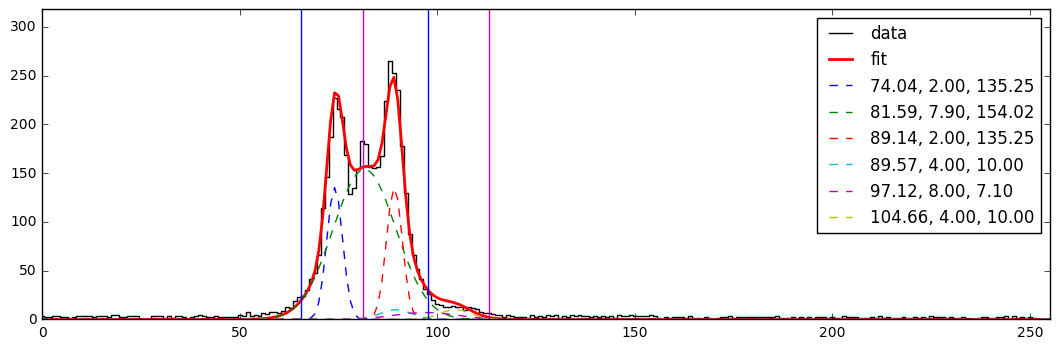

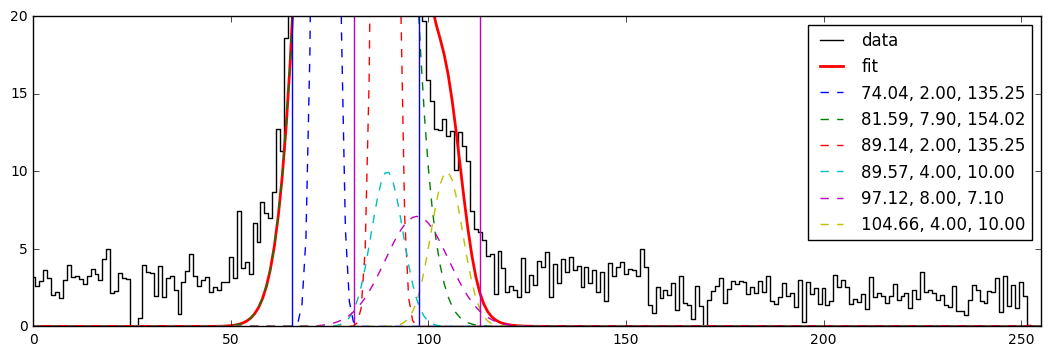

In [18]:
# Separate the orders. Nice-nice-nice-nice.
n = 2020
ord1, ord2 = spec1D.isolate_orders(data[:,n], plot=True)
ord1, ord2 = spec1D.isolate_orders(data[:,n], plot=True)
plt.ylim(0,20)

(0, 20)

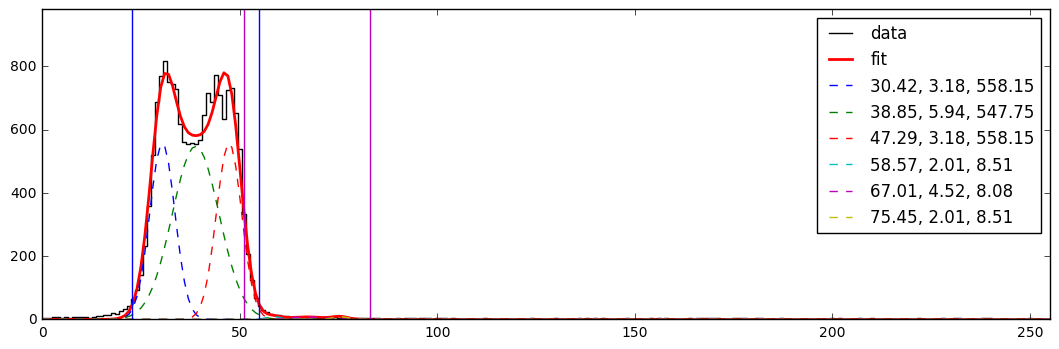

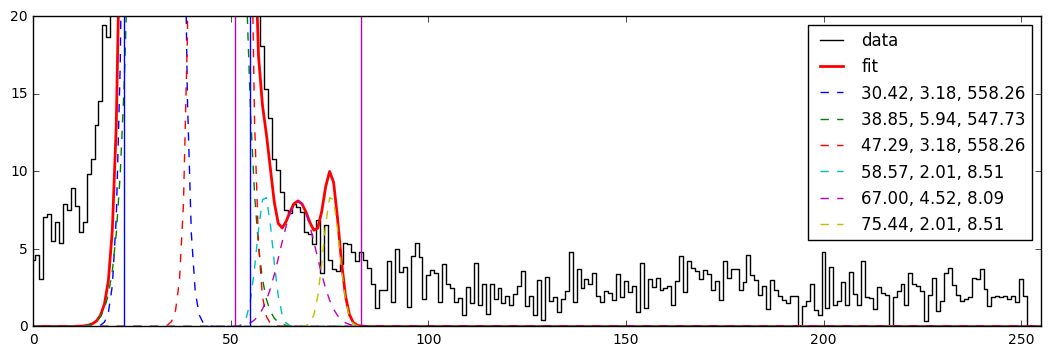

In [13]:
# What about region where only order 1 exists
n = 450
ord1, ord2 = spec1D.isolate_orders(data[:,n], plot=True)
ord1, ord2 = spec1D.isolate_orders(data[:,n], plot=True)
plt.ylim(0,20)

# Ok, will have to fit for batman only before order 2 starts then switch to fitting both

# Separate into orders 1 and 2

Now that the first and second order PSFs can be identified, extract full traces.

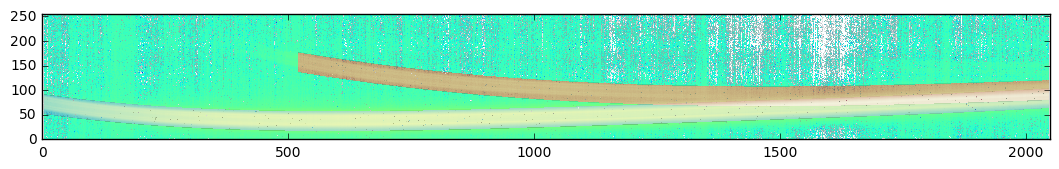

In [22]:
# Extract both traces... beautiful!
spec1, spec2 = spec1D.function_traces(data.T)

# Save the masks
np.save('order1_mask.npy', spec1.mask)
np.save('order2_mask.npy', spec2.mask)

In [15]:
# Load the masks
spec1 = np.ma.array(data.T, mask=np.load('order1_mask.npy'))
spec2 = np.ma.array(data.T, mask=np.load('order2_mask.npy'))

# Isolate order overlap

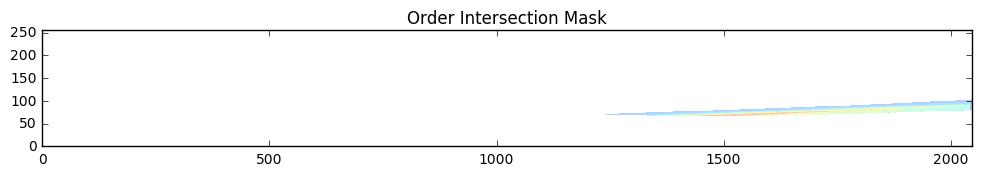

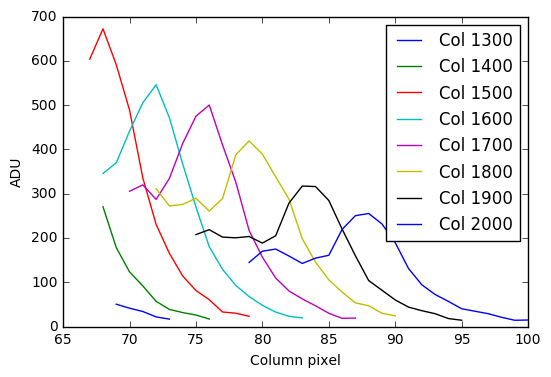

In [23]:
# Get mask for intersection
int_mask = np.ma.mask_or(spec1.T.mask,spec2.T.mask, copy=True)
intersection = np.ma.array(spec1.T, mask=int_mask)
plt.figure(figsize=(12,2))
plt.imshow(intersection, interpolation='none', origin='lower', alpha=0.3)
plt.title('Order Intersection Mask')

# Look at cross-section
plt.figure()
skip = 100
for n,i in enumerate(intersection.T[1::skip]):
    if any(i):
        plt.plot(i, label='Col {}'.format(skip*n))
plt.legend(loc=0)
plt.ylabel('ADU')
plt.xlabel('Column pixel')

# Background

Clipped 252 pixels beyond 12 sigma.


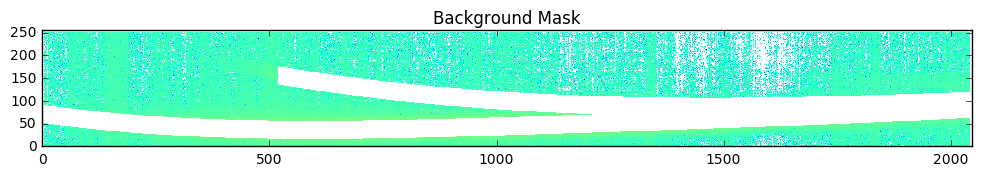

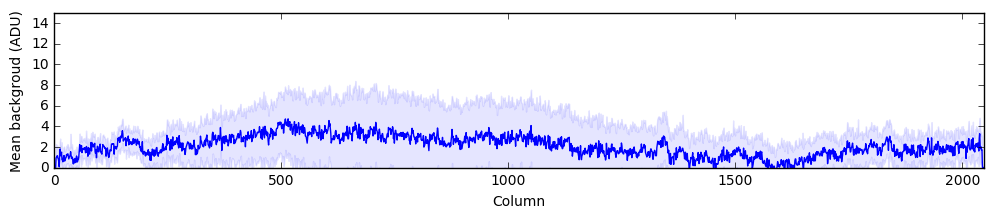

In [24]:
# Get mask for background
bkg_mask = np.logical_not(np.logical_and(spec1.mask,spec2.mask))
background = np.ma.array(spec1.data, mask=bkg_mask)
plt.figure(figsize=(12,2))
plt.imshow(background.T, interpolation='none', origin='lower', norm=LogNorm())
plt.title('Background Mask')

# Do sigma_clip then get mean background in each column and standard deviation
sigma = 12
clipped_background = sigma_clip(background, sigma=sigma)
print('Clipped {} pixels beyond {} sigma.'.format(background.count()-clipped_background.count(),sigma))
bkg_cols = np.mean(clipped_background, axis=1)
std = np.std(clipped_background, axis=1)

# Look at background column-by-column
plt.figure(figsize=(12,2))
plt.plot(range(len(bkg_cols)), bkg_cols, color='b')
plt.fill_between(range(len(bkg_cols)), bkg_cols-std, bkg_cols+std, alpha=0.1, color='b')
plt.xlim(0,2048)
plt.ylim(0,15)
plt.ylabel('Mean backgroud (ADU)')
plt.xlabel('Column')

# Look at wavelength solutions

In [25]:
# Get the wavelength calibration images
W = fits.getdata('./refs/soss_wavelengths_fullframe.fits').swapaxes(-1,-2)[:,:256]
lam1, lam2, _ = W
mn, mx = np.nanmin(W), np.nanmax(W)

# Get all the pixels that fall within a given wavelength bin
lam, d_lam = 0.9123, 0.002

# Plot the image with the relevant wavelength pixels indicated
for l,t in zip(W,['Order 1','Order 2']):
    pixels = np.where(np.logical_and(l>=lam-d_lam,l<lam+d_lam))
    plt.figure(figsize=(12,2))
    plt.imshow(l, interpolation='none', origin='lower', cmap=plt.cm.Spectral)
    find = np.zeros(l.shape)
    find[pixels] = 1
    plt.imshow(find, interpolation='none', origin='lower', alpha=0.2, cmap=plt.cm.Blues)
    plt.title(t)

FileNotFoundError: [Errno 2] No such file or directory: './refs/soss_wavelengths_fullframe.fits'

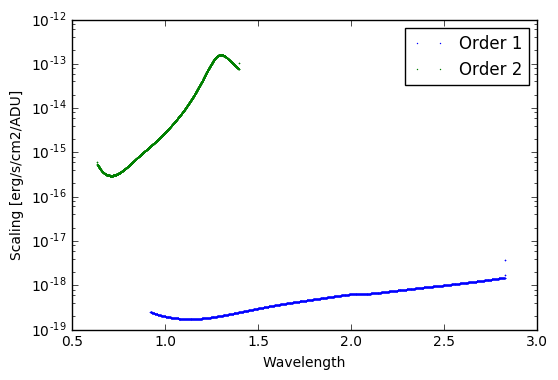

In [19]:
# Look at the scaling as a function of wavelength
scaling1, scaling2 = spec1D.ADUtoFlux(1), spec1D.ADUtoFlux(2)

# Plot it
plt.figure()
plt.plot(scaling1[0], scaling1[1], label='Order 1', marker='.', markersize=1, ls='none')
plt.plot(scaling2[0], scaling2[1], label='Order 2', marker='.', markersize=1, ls='none')
plt.legend(loc=0)
plt.yscale('log')
plt.ylabel('Scaling [erg/s/cm2/ADU]')
plt.xlabel('Wavelength')

Order 1: 167 pixels in 5 columns for wavelength bin 0.9103 < lambda < 0.9143
Order 2: 349 pixels in 9 columns for wavelength bin 0.9103 < lambda < 0.9143


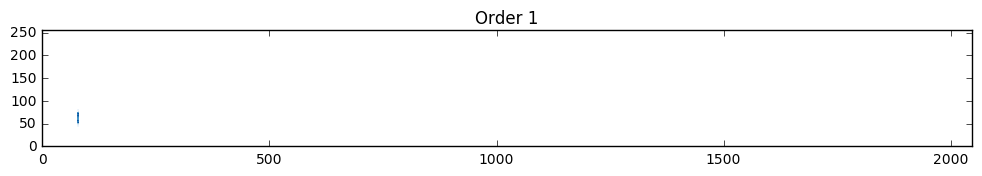

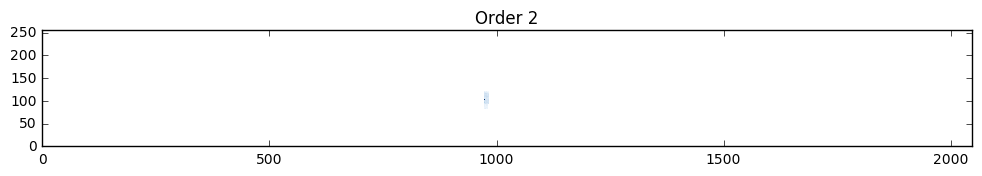

In [20]:
# Get the scaled flux from order 1 and order 2 of the same wavelength
msk1 = spec1D.fetch_pixels(lam, d_lam, 1, spec1, plot=True)
msk2 = spec1D.fetch_pixels(lam, d_lam, 2, spec2, plot=True)

Using wavelength bins stored in soss_1_wavelength_bins_0.002um.npy
1419 wavelength bins with width 0.002um for order 1


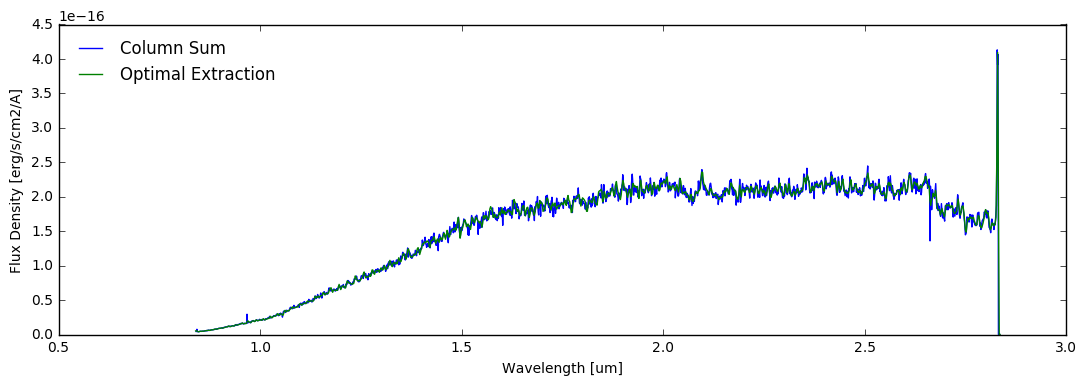

In [21]:
# Extract order 1 spectrum
d_lam1 = 0.002
wav1 = np.arange(np.min(lam2),np.max(lam1),d_lam1)
flx1 = spec1D.extract_flux(wav1, 1, spec1)

Using wavelength bins stored in soss_2_wavelength_bins_0.001um.npy
2837 wavelength bins with width 0.001um for order 2


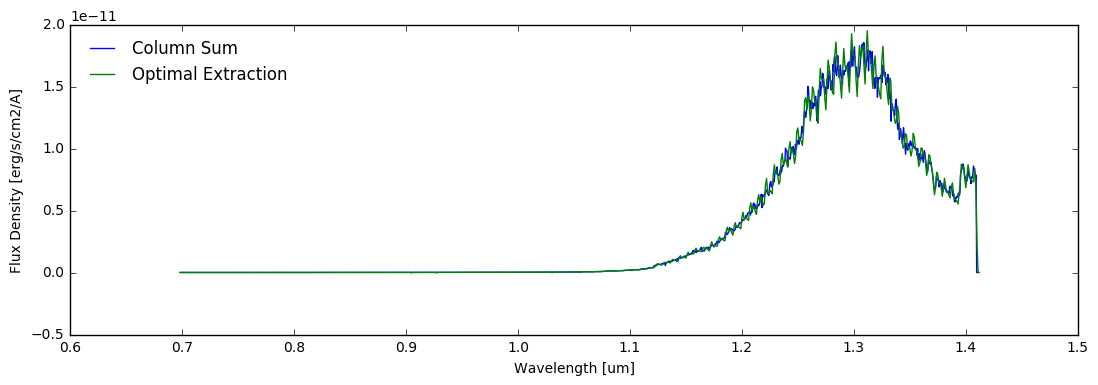

In [22]:
# Extract order 2 spectrum
d_lam2 = 0.001
wav2 = np.arange(np.min(lam2),np.max(lam1),d_lam2)
flx2 = spec1D.extract_flux(wav2, 2, spec2)